# Secondary Factors Check: SIZE & LIQUIDITY
This notebook evaluates SIZE secondary factors (MIDCAP, LNCAP) and LIQUIDITY secondary factors (Monthly/Quarterly/Annual turnover and Annualized traded value ratio).

In [32]:
import os
import sys
import numpy as np
import pandas as pd

sys.path.insert(0, '/home/ubuntu/code/cb_cache')
import cb_cache as cbc


In [33]:
# Parameters
start_date = 20140102
end_date = 20251224
holding_days = 20  # forward return window
quantiles = 10
root_path = '/home/ubuntu/scripts/cache_all'


In [34]:
# Load data with cb_cache
symbols = cbc.get_all_symbols()
cache = cbc.EqCache(symbols, start_date, end_date, root_path=root_path)

dates = cache.daily.dates
close = cache.daily.close

# SIZE secondary factors
midcap = cache.daily.MIDCAP
lncap = cache.daily.LNCAP

# LIQUIDITY secondary factors
monthly = cache.daily.Monthly_share_turnover
quarterly = cache.daily.Quarterly_share_turnover
annual = cache.daily.Annual_share_turnover
annualized = cache.daily.Annualized_traded_value_ratio


In [35]:
# Compute forward returns
fwd_ret = np.full_like(close, np.nan, dtype=np.float64)
if holding_days < close.shape[0]:
    fwd_ret[:-holding_days, :] = close[holding_days:, :] / close[:-holding_days, :] - 1.0

# Align for valid rows
valid_idx = np.arange(close.shape[0] - holding_days)
dates_eval = dates[valid_idx]
ret_eval = fwd_ret[valid_idx, :]

factors = {
    'MIDCAP': midcap[valid_idx, :],
    'LNCAP': lncap[valid_idx, :],
    'Monthly_share_turnover': monthly[valid_idx, :],
    'Quarterly_share_turnover': quarterly[valid_idx, :],
    'Annual_share_turnover': annual[valid_idx, :],
    'Annualized_traded_value_ratio': annualized[valid_idx, :],
}


<ipython-input-35-4663345b695a>:4: RuntimeWarning: divide by zero encountered in true_divide
  fwd_ret[:-holding_days, :] = close[holding_days:, :] / close[:-holding_days, :] - 1.0
<ipython-input-35-4663345b695a>:4: RuntimeWarning: invalid value encountered in true_divide
  fwd_ret[:-holding_days, :] = close[holding_days:, :] / close[:-holding_days, :] - 1.0


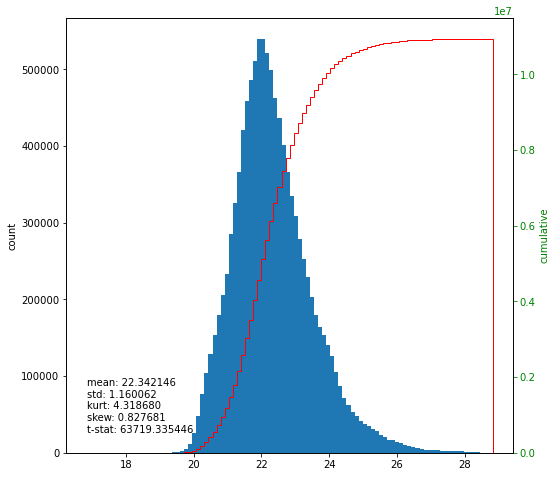

In [36]:
from python_utils.quant import *
axe_hist(lncap)

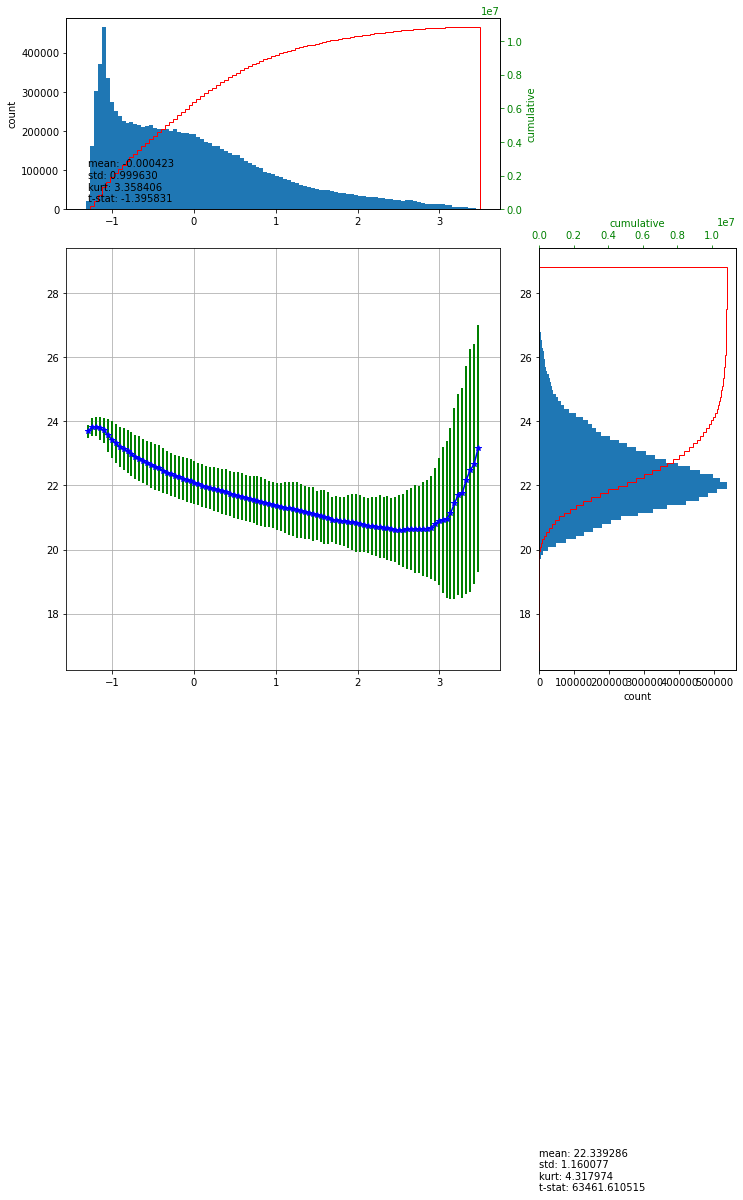

In [37]:
axe_equiplot(midcap[valid_idx], lncap[valid_idx])

In [38]:
def rank_ic(factor_row, ret_row):
    mask = np.isfinite(factor_row) & np.isfinite(ret_row)
    if mask.sum() < 10:
        return np.nan, np.nan
    f = pd.Series(factor_row[mask]).rank(pct=True)
    r = pd.Series(ret_row[mask]).rank(pct=True)
    return f.corr(r), pd.Series(factor_row[mask]).corr(pd.Series(ret_row[mask]))

def quantile_returns(factor_row, ret_row, q=10):
    mask = np.isfinite(factor_row) & np.isfinite(ret_row)
    if mask.sum() < q:
        return np.full(q, np.nan)
    f = pd.Series(factor_row[mask])
    r = pd.Series(ret_row[mask])
    bins = pd.qcut(f.rank(method='first'), q, labels=False)
    return r.groupby(bins).mean().reindex(range(q)).to_numpy()


In [39]:
# IC / RankIC time series for all factors
records = []

for name, mat in factors.items():
    ic_list, ric_list = [], []
    for i in range(len(dates_eval)):
        ric, ic = rank_ic(mat[i], ret_eval[i])
        ic_list.append(ic)
        ric_list.append(ric)
    records.append(pd.DataFrame({
        'date': dates_eval,
        'factor': name,
        'ic': ic_list,
        'rank_ic': ric_list,
    }))

ic_df = pd.concat(records, ignore_index=True)
ic_df.head()


,date,factor,ic,rank_ic
0,20140102,MIDCAP,0.126850,0.186087
1,20140103,MIDCAP,0.111603,0.165518
2,20140106,MIDCAP,0.132206,0.178018
3,20140107,MIDCAP,0.119489,0.152423
4,20140108,MIDCAP,0.134857,0.177718


In [40]:
# IC summary
def ic_summary(df):
    out = []
    for name, grp in df.groupby('factor'):
        ic = grp['ic'].dropna()
        ric = grp['rank_ic'].dropna()
        out.append({
            'factor': name,
            'ic_mean': ic.mean(),
            'ic_std': ic.std(),
            'ic_ir': ic.mean() / ic.std() if ic.std() > 0 else np.nan,
            'rank_ic_mean': ric.mean(),
            'rank_ic_std': ric.std(),
            'rank_ic_ir': ric.mean() / ric.std() if ric.std() > 0 else np.nan,
            'count': ic.size,
        })
    return pd.DataFrame(out).sort_values('rank_ic_ir', ascending=False)

summary = ic_summary(ic_df)
summary


,factor,ic_mean,ic_std,ic_ir,rank_ic_mean,rank_ic_std,rank_ic_ir,count
3,MIDCAP,0.051484,0.135734,0.379301,0.038112,0.177062,0.215244,2870
2,LNCAP,-0.042037,0.158602,-0.265044,-0.035576,0.199019,-0.178757,2870
0,Annual_share_turnover,-0.037088,0.153156,-0.242156,-0.060001,0.183308,-0.327325,2626
1,Annualized_traded_value_ratio,-0.057669,0.126179,-0.457043,-0.078590,0.189073,-0.415661,2626
5,Quarterly_share_turnover,-0.050934,0.158712,-0.320919,-0.082127,0.187691,-0.437565,2626
4,Monthly_share_turnover,-0.060289,0.160331,-0.376029,-0.096162,0.187127,-0.513887,2626


In [ ]:
# Quantile group returns (average across dates)
group_rows = []

for name, mat in factors.items():
    group_series = []
    for i in range(len(dates_eval)):
        group_series.append(quantile_returns(mat[i], ret_eval[i], q=quantiles))
    avg_groups = np.nanmean(np.vstack(group_series), axis=0)
    for g in range(quantiles):
        group_rows.append({
            'factor': name,
            'group': g + 1,
            'group_ret': avg_groups[g],
        })

group_df = pd.DataFrame(group_rows)
group_df


In [ ]:
# Save outputs
ic_df.to_csv('/home/ubuntu/scripts/cache_all/secondary_factor_ic.csv', index=False)
summary.to_csv('/home/ubuntu/scripts/cache_all/secondary_factor_ic_summary.csv', index=False)
group_df.to_csv('/home/ubuntu/scripts/cache_all/secondary_factor_group_returns.csv', index=False)
'/home/ubuntu/scripts/cache_all/secondary_factor_ic.csv', '/home/ubuntu/scripts/cache_all/secondary_factor_ic_summary.csv', '/home/ubuntu/scripts/cache_all/secondary_factor_group_returns.csv'


('/home/ubuntu/scripts/cache_all/secondary_factor_ic.csv',
 '/home/ubuntu/scripts/cache_all/secondary_factor_ic_summary.csv',
 '/home/ubuntu/scripts/cache_all/secondary_factor_group_returns.csv')